In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore");

In [2]:
def load_data(path):
    df = pd.read_csv(path)
    df = df[5::6].reset_index(drop=True)
    return df

In [3]:
def feature_engineering(df):
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    df = df.iloc[:,[0, 1, 2, 5, 7, 8, 10, 11]]
    df['week_of_year'] = df['Date Time'].dt.isocalendar().week
    return df

In [4]:
def nature_transforming(df):
    df['week_of_year_sin'] = df['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
    df['week_of_year_cos'] = df['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
    df.drop('week_of_year',axis=1,inplace=True)
    return df

In [5]:
def split_train_test(df):
    X_train = df[df['Date Time'] < '2015-01-01 00:00:00']
    y_train = X_train['T (degC)']
    X_test = df[df['Date Time'] >= '2015-01-01 01:00:00']
    y_test = X_test['T (degC)']
    return X_train, y_train, X_test, y_test

In [6]:
def reescaling(X_train,X_test):
    from sklearn import preprocessing as pp
    ss_pmbar = pp.StandardScaler()
    ss_rh = pp.StandardScaler()
    ss_vpact = pp.StandardScaler()
    ss_vpdef = pp.StandardScaler()
    ss_h2oc = pp.StandardScaler()
    ss_rho = pp.StandardScaler()
    X_train['p (mbar)'] = ss_pmbar.fit_transform(X_train[['p (mbar)']].values)
    X_train['rh (%)'] = ss_rh.fit_transform(X_train[['rh (%)']].values)
    X_train['VPact (mbar)'] = ss_vpact.fit_transform(X_train[['VPact (mbar)']].values)
    X_train['VPdef (mbar)'] = ss_vpdef.fit_transform(X_train[['VPdef (mbar)']].values)
    X_train['H2OC (mmol/mol)'] = ss_h2oc.fit_transform(X_train[['H2OC (mmol/mol)']].values)
    X_train['rho (g/m**3)'] = ss_rho.fit_transform(X_train[['rho (g/m**3)']].values)
    X_test['p (mbar)'] = ss_pmbar.transform(X_test[['p (mbar)']].values)
    X_test['rh (%)'] = ss_rh.transform(X_test[['rh (%)']].values)
    X_test['VPact (mbar)'] = ss_vpact.transform(X_test[['VPact (mbar)']].values)
    X_test['VPdef (mbar)'] = ss_vpdef.transform(X_test[['VPdef (mbar)']].values)
    X_test['H2OC (mmol/mol)'] = ss_h2oc.transform(X_test[['H2OC (mmol/mol)']].values)
    X_test['rho (g/m**3)'] = ss_rho.transform(X_test[['rho (g/m**3)']].values)
    return X_train, X_test

In [7]:
def feature_selection(X_train,X_test):
    cols_selected_boruta = ['p (mbar)','rh (%)','VPact (mbar)','VPdef (mbar)','H2OC (mmol/mol)','rho (g/m**3)','week_of_year_cos']
    x_train = X_train[cols_selected_boruta]
    x_test = X_test[cols_selected_boruta]
    return x_train, x_test

In [17]:
def prediction(x_train,y_train,x_test):
    from sklearn.linear_model import LinearRegression
    model = LinearRegression().fit(x_train,y_train)
    yhat_lr = model.predict(x_test)
    return yhat_lr, model

In [9]:
def get_metrics(yhat_lr,y_test):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    mae = mean_absolute_error(y_test,yhat_lr)
    mse = mean_squared_error(y_test,yhat_lr)
    rmse = np.sqrt(mean_squared_error(y_test,yhat_lr))
    return {'MAE':mae,'MSE':mse,'RMSE':rmse}

In [18]:
df1 = load_data('jena_climate_2009_2016.csv')
df2 = feature_engineering(df1)
df3 = nature_transforming(df2)
X_train, y_train, X_test, y_test = split_train_test(df3)
X_train, X_test = reescaling(X_train,X_test)
x_train, x_test = feature_selection(X_train,X_test)
yhat_lr, model= prediction(x_train,y_train,x_test)
get_metrics(yhat_lr,y_test)

{'MAE': 0.04799540588550491,
 'MSE': 0.005399414853396968,
 'RMSE': 0.07348071075729308}

In [27]:
def create_graphs(y_test,yhat_lr,X_test):
    import matplotlib.pyplot as plt
    import seaborn as sns
    resultado = pd.DataFrame()
    resultado['y'] = y_test
    resultado['yhat'] = yhat_lr
    resultado['date'] = X_test['Date Time']
    resultado['error'] = resultado['y'] - resultado['yhat']
    plt.figure(figsize=(10,6))
    plt.subplot( 2, 1, 1 )
    sns.distplot( resultado['error'] )
    plt.subplot( 2, 1, 2 )
    sns.scatterplot( resultado['yhat'], resultado['error'] )
    plt.savefig('error_graphs.png')

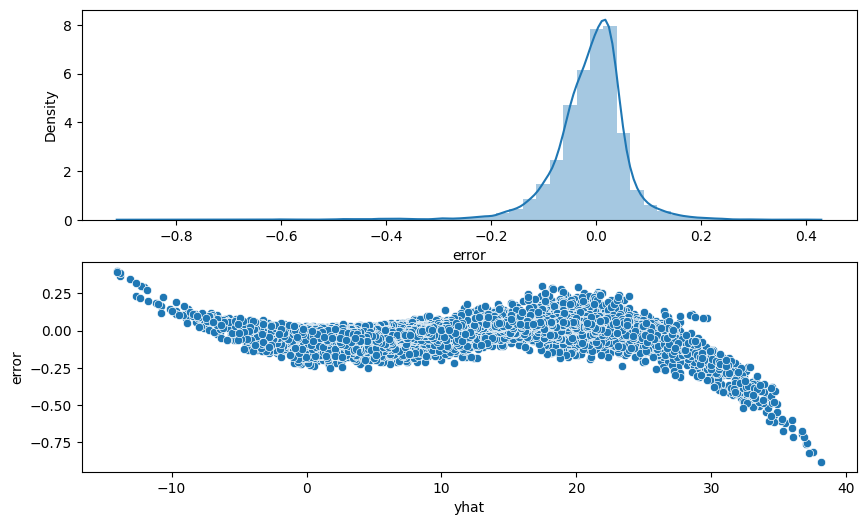

In [28]:
create_graphs(y_test,yhat_lr,X_test)

In [36]:
def create_experiment(experiment_name, run_name, run_metrics, model, graphs_path = None, run_params = None):
    import mlflow
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run():
        if not run_params == None:
            for param in run_params:
                mlflow.log_param(param,run_params[param])
        for metric in run_metrics:
            mlflow.log_metric(metric,run_metrics[metric])
        mlflow.sklearn.log_model(model,'model')
        if not graphs_path == None:
            mlflow.log_artifact(graphs_path,'graph')
        mlflow.set_tag('tag1','Linear Regression')
    print('Run : {} is logged to Experiment : {}'.format(run_name,experiment_name))

In [34]:
experiment_name = 'regression'
run_name = 'run'
run_metrics = get_metrics(yhat_lr,y_test)
print(run_metrics)

{'MAE': 0.04799540588550491, 'MSE': 0.005399414853396968, 'RMSE': 0.07348071075729308}


In [35]:
create_experiment(experiment_name,run_name,run_metrics,model,'error_graphs.png')

Run - run is logged to Experiment - regression
